In [2]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF
from torchvision import transforms, utils,datasets
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

import glob

##### Define data paths

In [3]:
#get all image and mask paths
image_paths = glob.glob("C:\\Users\\Alexandra\\Desktop\\thesis\\9_week\\data\\imgB\\*.jpg")
mask_paths = glob.glob("C:\\Users\\Alexandra\\Desktop\\thesis\\9_week\\data\\mskB\\*.jpg")

#split paths
len_images = len(image_paths)
print(len_images)
train_size = 0.8

#length of image and mask folder is the same
train_image_paths = image_paths [:int(len_images*train_size)]
test_image_paths = image_paths[int(len_images*train_size):]

train_mask_paths = mask_paths [:int(len_images*train_size)]
test_mask_paths = mask_paths[int(len_images*train_size):]


50


In [4]:
#torch.set_printoptions(profile="full")

##### Custom dataset

In [5]:
#dataset class
class image_dataset(Dataset):
    def __init__(self, images, masks, train=True):
        self.images = images
        self.masks = masks
#         self.num_classes = num_classes
#         self.transforms = transforms

    def transform(self, image,mask):
        resize_im = transforms.Resize(size = (256,256), interpolation=Image.NEAREST)
        resize_m = transforms.Resize(size = (256,256), interpolation=Image.NEAREST)
        gray =  transforms.Grayscale(num_output_channels=1)
        
        image = resize_im(image)
        mask = resize_m(mask)
        
        image = gray(image)
        mask = gray(mask)
        
        
        ####
        image = TF.to_tensor(image)
        mask = TF.to_tensor(mask)
        mask = mask.__ge__(0.7).type(torch.FloatTensor) 
        return image,mask
        
    def __getitem__(self, idx):
        image = Image.open(self.images[idx])
        mask = Image.open(self.masks[idx])        
        x,y = self.transform(image,mask)
        return x,y
        
    def __len__(self):
        return len(self.images)


In [6]:
train_data = image_dataset(train_image_paths, train_mask_paths, train=True)
train_loader = DataLoader(train_data, batch_size = 3, shuffle = True)

test_data = image_dataset(test_image_paths, test_mask_paths, train = False)
test_loader = DataLoader(test_data, batch_size = 3, shuffle = False)

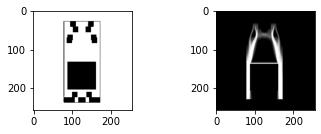

torch.Size([1, 256, 256])


In [7]:
fig = plt.figure()
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(train_data[0][1][0],cmap ='gray')
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(train_data[0][0][0],cmap ='gray')
plt.show()
#print(train_data[1][1])
print(train_data[0][0].shape)

In [8]:
# Use gpu for training if available else use cpu
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [9]:
def Conv_double(in_chans, out_chans):
    conv = nn.Sequential(
        nn.Conv2d(in_chans,out_chans, kernel_size =3,padding =1),
        nn.BatchNorm2d(out_chans),
        nn.ReLU(inplace = True),
        nn.Conv2d(out_chans, out_chans, kernel_size =3,padding = 1),
        nn.BatchNorm2d(out_chans),
        nn.ReLU(inplace=True)
    )
    return conv

def Crop_tensor(source, target):
    target_size = target.size()[2]
    source_size = source.size()[2]
    d = source_size - target_size
    if d>1:
        d = (int)(d // 2)
        return source[:,:,d:source_size-d, d:source_size-d]
    else:
        return source[:,:,d:source_size, d:source_size]

In [10]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.maxpool = nn.MaxPool2d(kernel_size =2, stride =2)
        
        #convolutions
        self.down_conv1 = Conv_double(1,64)
        self.down_conv2 = Conv_double(64, 128)
        self.down_conv3 = Conv_double(128, 256)
        self.down_conv4 = Conv_double(256, 512)
        self.down_conv5 = Conv_double(512, 1024)
        
        #up-convolutions
        self.conv_trans1 = nn.ConvTranspose2d(in_channels = 1024, out_channels = 512, kernel_size=2, stride=2)
        self.up_conv1 = Conv_double(1024, 512)
        
        self.conv_trans2 = nn.ConvTranspose2d(in_channels = 512, out_channels = 256, kernel_size=2, stride=2)
        self.up_conv2 = Conv_double(512, 256)
        
        self.conv_trans3 = nn.ConvTranspose2d(in_channels = 256, out_channels = 128, kernel_size=2, stride=2)
        self.up_conv3 = Conv_double(256, 128)
        
        self.conv_trans4 = nn.ConvTranspose2d(in_channels = 128, out_channels = 64, kernel_size=2, stride=2)
        self.up_conv4 = Conv_double(128, 64)
    
        #output
        self.out = nn.Conv2d(in_channels = 64, out_channels = 1,kernel_size=1)
        
        #weights
#         for m in self.modules():
#                     if isinstance(m, nn.Conv2d):
#                             n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
#                             m.weight.data.normal_(0, math.sqrt(2. / n))


        
    def forward(self, img):
        #bs,c,h,w
        #encoder
        x1 = self.down_conv1(img) # 
        x2 = self.maxpool(x1)
        x3 = self.down_conv2(x2)   #
        x4 = self.maxpool(x3)
        x5 = self.down_conv3(x4)   #
        x6 = self.maxpool(x5)
        x7 = self.down_conv4(x6)   #
        x8 = self.maxpool(x7)
        x9 = self.down_conv5(x8) 
        
        #decoder
        x = self.conv_trans1(x9)  
        #crop tensor
        y = Crop_tensor(x7, x)        
        #conacatenate
        x = self.up_conv1(torch.cat([x,y],1))
        
        x = self.conv_trans2(x)        
        y = Crop_tensor(x5, x)        
        x = self.up_conv2(torch.cat([x,y],1))
      
        x = self.conv_trans3(x)        
        y = Crop_tensor(x3, x)
        x = self.up_conv3(torch.cat([x,y],1))

        x = self.conv_trans4(x)        
        y = Crop_tensor(x1, x)
        x = self.up_conv4(torch.cat([x,y],1))
 
        x = self.out(x)
    
        return x
  

In [ ]:
def weights_init(m):
#     classname = m.__class__.__name__
#     if classname.find('Conv2d') != -1:
#         torch.nn.init.normal_(m.weight, 0.0, 0.02)
#     elif classname.find('BatchNorm2d') != -1:
#         torch.nn.init.normal_(m.weight, 1.0, 0.02)
#         torch.nn.init.zeros_(m.bias)


In [11]:
def weights_init(m): 
    if isinstance(m, nn.Conv2d): 
        nn.init.xavier_normal_(m.weight.data, gain = 1.0) 
        #nn.init.xavier_normal_(m.bias.data)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight,1)
        nn.init.constant_(m.bias, 0)


In [12]:
import math

In [13]:
model = UNet()
model = model.to(device)
model.apply(weights_init)
print(model)

UNet(
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (down_conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (down_conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (down_conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 

In [14]:
test_im = torch.rand(1,1,256,256)
test_im = test_im.to(device)
outputs = model(test_im)

In [ ]:
def Apply_filter(masks):
    m_f=[]
    for i,msk in enumerate(masks):
        klen = 10
        kernel = np.ones(klen)
        k = np.ones([1,20,20])
        msk = gaussian_filter(msk,10) 
        m_f.append(msk)
    return torch.from_numpy(m_f)

In [ ]:
outputs.shape

In [15]:
learning_rate = 0.001
criterion = nn.BCEWithLogitsLoss()
#criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [16]:
# The training loop
epochs = 800
total_steps = len(train_loader)
#print(f"{epochs} epochs, {total_steps} total_steps per epoch")
for epoch in range(epochs):
    total_train = 0
    correct_train = 0
    for i, (images, masks) in enumerate(train_loader):
        #print(masks.shape)

        images = images.to(device)
        
#         #blur masks-2 in the batch
#         masks[0] = torch.from_numpy(gaussian_filter(masks[0],2))
#         masks[1] = torch.from_numpy(gaussian_filter(masks[1],2))
        
        masks = masks.to(device)


        # Forward pass
        outputs = model(masks)
        
        softmax = torch.nn.functional.log_softmax(outputs, dim=1)
        loss = criterion(outputs, images)
       
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_train += images.nelement()
        correct_train += (predicted == masks).sum().item()
        train_accuracy = 100 * correct_train / total_train
         
        if (i) % 100 == 0:
            print (f"Epoch [{epoch + 1}/{epochs}], Step [{i}/{total_steps}], Loss: {loss.item():4f}, Accuracy:{train_accuracy}")

torch.Size([3, 1, 256, 256])
Epoch [1/800], Step [0/14], Loss: 0.635885, Accuracy:32.763671875
torch.Size([3, 1, 256, 256])
torch.Size([3, 1, 256, 256])
torch.Size([3, 1, 256, 256])
torch.Size([3, 1, 256, 256])
torch.Size([3, 1, 256, 256])


KeyboardInterrupt: 

In [ ]:
from scipy.ndimage import uniform_filter1d, convolve1d, convolve,gaussian_filter

NameError: name 'masks_f' is not defined

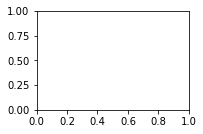

In [17]:
fig = plt.figure()
ax1 = fig.add_subplot(2,2,1)
image = masks_f[1].cpu().detach().numpy()
ax1.imshow(np.squeeze(image),cmap = 'gray')
plt.show()

In [ ]:
im = np.random.rand(256,256,3)

In [ ]:
fig = plt.figure()
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(im)
plt.show()

In [ ]:
criterion(out[0],images[0])

loss: tensor(0.4369, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
test accuracy: 37.99568176269531


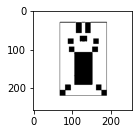

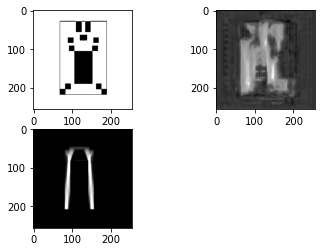

loss: tensor(0.2790, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
test accuracy: 37.99568176269531


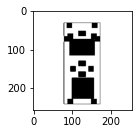

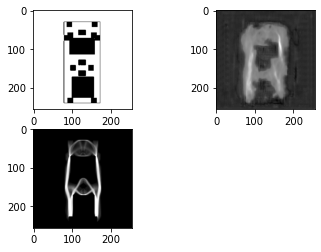

loss: tensor(0.3531, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
test accuracy: 37.99568176269531


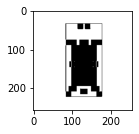

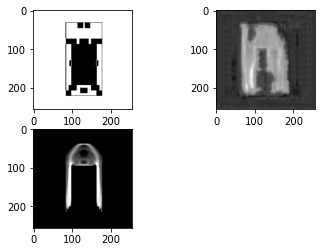

loss: tensor(0.2277, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
test accuracy: 37.99568176269531


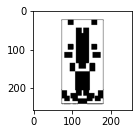

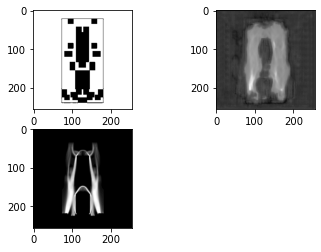

In [12]:
total_test = 0
correct_test = 0

for i, (images, masks) in enumerate(test_loader):
    
#     #blur masks-2 in the batch
#     masks[0] = torch.from_numpy(gaussian_filter(masks[0],10))
#     masks[1] = torch.from_numpy(gaussian_filter(masks[1],1))
    
    fig = plt.figure()
    ax1 = fig.add_subplot(2,2,1)
    ax1.imshow(np.squeeze(masks[0].cpu().detach().numpy()),cmap = 'gray')
    
    masks = masks.to(device)
    images = images.to(device)
    output = model(masks)
    softmax = torch.nn.functional.log_softmax(output, dim=1)
    loss = criterion(output, images)
   
    print("loss:", loss)
    
     # accuracy
    _, predicted = torch.max(output.data, 1)
    total_test += images.nelement()
    correct_test += (predicted == masks).sum().item()
    test_accuracy = 100 * correct_train / total_train
    print("test accuracy:", test_accuracy)

    fig = plt.figure()
    ax1 = fig.add_subplot(2,2,1)
    ax1.imshow(np.squeeze(masks[0].cpu().detach().numpy()),cmap = 'gray')
    ax2 = fig.add_subplot(2,2,2)
    ax2.imshow(np.squeeze(output[0].cpu().detach().numpy()),cmap = 'gray')
    
    ax3 = fig.add_subplot(2,2,3)
    ax3.imshow(np.squeeze(images[0].cpu().detach().numpy()),cmap = 'gray')
    
    plt.show()


In [ ]:
image = Image.open('test_textures/boat.jpg')
img = image.resize((300,300))
img = img.convert('L')
display(img)
print(img)
print(img.size)

#connvert to tensor
trans1 = transforms.ToTensor()
img = trans1(img).view(1,1,300,300)
print(img.shape)

In [ ]:
image = torch.rand((1,1,300,300))

In [ ]:
outputs = model(img.to(device))
img1 = np.squeeze(outputs[0].cpu().detach().numpy())
print(img1.shape)
plt.imshow(img1)
plt.show()


In [ ]:
img3 = np.squeeze(myImage.detach().numpy())
img3 = (img3)
print(img3.shape)
plt.imshow(img3)
plt.show()